In [141]:
import matplotlib.pyplot as plt
import dill
import sympy
from tqdm import tqdm
from scipy.sparse import lil_matrix, csc_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import pypardiso
import plotly

### Load precomputed integrals

In [142]:
lagrange_linear_poisson_matrix = dill.load(
    open("../../calculations/lagrange_linear_poisson_matrix", "rb")
)
lagrange_linear_poisson_right_values = dill.load(
    open("../../calculations/lagrange_linear_poisson_right_values", "rb")
)
consistency_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_consistency", "rb")
)
consistency_boundary_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_consistency_boundary", "rb")
)
symmetricity_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_symmetricity", "rb")
)
symmetricity_boundary_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_symmetricity_boundary", "rb")
)
penalty_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_penalty", "rb")
)
penalty_boundary_lambdified = dill.load(
    open("../../calculations/lagrange_linear_poisson_dg_penalty_boundary", "rb")
)

bc_dirichlet_lambdified = dill.load(open("../../calculations/lagrange_linear_poisson_dg_bc_dirichlet", "rb"))
bc_neumann_lambdified = dill.load(open("../../calculations/lagrange_linear_poisson_dg_bc_neumann", "rb"))

### Initialize the domain

In [143]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt


gmsh.initialize()
gmsh.model.add("tri_mesh")

ms = 0.025
# Define points
point_1 = gmsh.model.geo.addPoint(0, 0, 0, ms)
point_2 = gmsh.model.geo.addPoint(1, 0, 0, ms)
point_3 = gmsh.model.geo.addPoint(0, 1, 0, ms)
point_4 = gmsh.model.geo.addPoint(-1, 0, 0, ms)
point_5 = gmsh.model.geo.addPoint(0, -1, 0, ms)

# Define circles
arc_1 = gmsh.model.geo.addCircleArc(point_2, point_1, point_3)
arc_2 = gmsh.model.geo.addCircleArc(point_3, point_1, point_4)
arc_3 = gmsh.model.geo.addCircleArc(point_4, point_1, point_5)
arc_4 = gmsh.model.geo.addCircleArc(point_5, point_1, point_2)

# Define line loop
circle = gmsh.model.geo.addCurveLoop([arc_1, arc_2, arc_3, arc_4])

# Define plane surface
plane = gmsh.model.geo.addPlaneSurface([circle])

gmsh.model.geo.synchronize()

ms = 21
gmsh.model.mesh.setTransfiniteCurve(arc_1, ms)
gmsh.model.mesh.setTransfiniteCurve(arc_2, ms)
gmsh.model.mesh.setTransfiniteCurve(arc_3, ms)
gmsh.model.mesh.setTransfiniteCurve(arc_4, ms)
gmsh.model.mesh.setTransfiniteSurface(plane)

neumann_tag = gmsh.model.addPhysicalGroup(1, [arc_1], name="Neuman")

physical_group_curves_tag = gmsh.model.addPhysicalGroup(1, [arc_1, arc_2, arc_3, arc_4], name="Boundary curves")
physical_group_surface_tag = gmsh.model.addPhysicalGroup(2, [plane], name="Surface")


# point_tag = gmsh.model.geo.addPoint(np.sqrt(1/2), np.sqrt(1/2), 0, 1)
# gmsh.model.geo.synchronize()

# # Define the Attractor field
# attractor_field = gmsh.model.mesh.field.add("Attractor")
# gmsh.model.mesh.field.setNumbers(attractor_field, "NodesList", [point_tag])

# # Define the Threshold field
# threshold_field = gmsh.model.mesh.field.add("Threshold")
# gmsh.model.mesh.field.setNumber(threshold_field, "IField", attractor_field)
# gmsh.model.mesh.field.setNumber(threshold_field, "LcMin", 0.001)
# gmsh.model.mesh.field.setNumber(threshold_field, "LcMax", 0.1)
# gmsh.model.mesh.field.setNumber(threshold_field, "DistMin", 0.01)
# gmsh.model.mesh.field.setNumber(threshold_field, "DistMax", 0.5)

# # Set the Threshold field as the background field
# gmsh.model.mesh.field.setAsBackgroundMesh(threshold_field)


gmsh.model.mesh.generate(2)
gmsh.fltk.run()

In [144]:
edge_entities = gmsh.model.getEntitiesForPhysicalGroup(dim=1, tag=neumann_tag)

edge_elemTags, edge_nodeTags = [], []
for e in edge_entities:
    _, elemTags, nodeTags = gmsh.model.mesh.getElements(1, e)
    edge_elemTags.extend(np.hstack(elemTags))
    edge_nodeTags.extend(np.hstack(nodeTags))

# Triangles

In [145]:
boundary_node_tags, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, physical_group_curves_tag)
surface_node_tags, points = gmsh.model.mesh.getNodesForPhysicalGroup(2, physical_group_surface_tag)
points = points.reshape(-1, 3)[:, :-1]
boundary_node_tags = boundary_node_tags - 1

In [146]:
tri_tags, tri_nodes = gmsh.model.mesh.getElementsByType(2)

In [147]:
# get triangles to edges
edge_nodes = gmsh.model.mesh.getElementEdgeNodes(2)
# (nTriangles * nEdgesPerTriangle * nNodesPerEdge)
# edge_nodes.reshape(-1, 3, 2)

In [148]:
gmsh.model.mesh.createEdges()  # forces Gmsh to assign unique tags to edges
edge_tags, edge_node_pairs = gmsh.model.mesh.getAllEdges() 
edge_node_pairs

array([ 42,  43,  41, ..., 400, 408, 389], dtype=uint64)

In [149]:
element_types, element_tags, element_node_tags = gmsh.model.mesh.getElements()

gmsh.model.mesh.getElement(element_tags[1][10])

(2, array([76, 85, 75], dtype=uint64), 2, 1)

In [150]:
element_types, element_tags, element_node_tags = gmsh.model.mesh.getElements()
triangles = [nodes for elem_type, nodes in zip(element_types, element_node_tags) if elem_type == 2][0]
triangles = triangles.reshape(-1, 3)
triangles = triangles - 1

def orient_batch(arg):
    indices = np.argsort(arg, axis=-1)
    res = np.take_along_axis(arg, indices, axis=-1)

    return res

triangles = orient_batch(triangles)

In [151]:
vertex_marker_is_boundary = np.zeros(surface_node_tags.shape[0])
vertex_marker_is_boundary[boundary_node_tags] = 1

In [152]:
all_edges = triangles[:, [[1, 2], [0, 2], [0, 1]]].reshape(-1, 2)
all_edges = np.sort(all_edges, axis=-1)
all_edges, _, indices, counts = np.unique(all_edges, axis=0, return_counts=True, return_inverse=True, return_index=True)
edge_marker_is_boundary = (counts == 1).astype(int)[:, None]

## Triangles to edges

In [153]:
triangles_to_edges = indices.reshape(-1, 3)

## Vertices to edges

In [154]:
vertices_to_edges = []

for test_idx in range(points.shape[0]):
    vertices_to_edges.append([])

for e_idx, edge in enumerate(all_edges):
    for pidx in edge:
        vertices_to_edges[pidx].append(e_idx)

## Edges to edges

In [155]:
edges_to_edges = []

for test_idx in range(all_edges.shape[0]):
    edges_to_edges.append([])

for e_idx, edge in enumerate(all_edges):
    
    edges_to_edges[e_idx].extend(vertices_to_edges[edge[0]])
    edges_to_edges[e_idx].extend(vertices_to_edges[edge[1]])
    edges_to_edges[e_idx] = list(set(edges_to_edges[e_idx]))
    edges_to_edges[e_idx].remove(e_idx)

## Edges to triangles

In [156]:
edges_to_triangles = []

for test_idx in range(all_edges.shape[0]):
    edges_to_triangles.append([])

for t_idx, edge in enumerate(triangles_to_edges):
    
    for e_idx in edge:
        edges_to_triangles[e_idx].append(t_idx)

for t_idx, v in enumerate(edges_to_triangles):
    if len(v) == 1:
        edges_to_triangles[t_idx].append(-1)

edges_to_triangles = np.array(edges_to_triangles)

# Vertices to triangles

In [157]:
vertices_to_triangles = []

for i in range(points.shape[0]):
    vertices_to_triangles.append([])

for cidx, cell in enumerate(triangles):
    for pidx in cell:
        vertices_to_triangles[pidx].append(cidx)

In [202]:
def get_adjaset_triangles(edge: int) -> np.ndarray:
    """Returns the idx of the triangles that share the edge.

    Args:
        edge (int): edge index

    Returns:
        np.ndarray: triangle indices
    """
    triangle_idx = edges_to_triangles[edge]

    if triangle_idx[1] == -1:
        triangle_idx = triangle_idx[:1]

    triangle_idx.sort(axis=-1)

    return triangle_idx

In [254]:
x, y = sympy.symbols("x y")

In [255]:
F = sympy.Float(0)
right_vals = np.zeros((points.shape[0]))
right_vals[:] = sympy.lambdify((x, y), F)(*points.T)

D = sympy.Float(1)
bc_dirichlet = np.zeros((points.shape[0]))
bc_dirichlet[:] = sympy.lambdify((x, y), D)(*points.T)

N = -sympy.Float(1)
bc_neumann = np.zeros((points.shape[0]))
bc_neumann[:] = sympy.lambdify((x, y), N)(*points.T)

In [257]:
num_unknowns = triangles.shape[0] * 3
stiffness_matrix = lil_matrix((num_unknowns, num_unknowns), dtype=np.float64)
b = np.zeros((num_unknowns), dtype=np.float64)

for t_idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    FF = lagrange_linear_poisson_matrix(x1, y1, x2, y2, x3, y3)
    ff = lagrange_linear_poisson_right_values(x1, y1, x2, y2, x3, y3, right_vals[element[0]], right_vals[element[1]], right_vals[element[2]])

    for test_idx in range(3):
        for trial_idx in range(3): 
            stiffness_matrix[3*t_idx + trial_idx, 3*t_idx + test_idx] += FF[trial_idx, test_idx]
        b[3*t_idx + test_idx] -= ff[test_idx, 0]


P = 20
for e_idx, _ in enumerate(tqdm(all_edges)):

    nt_idx = get_adjaset_triangles(e_idx)
    triangles_points = triangles[nt_idx]
    triangle_point_coords = points[triangles_points]    
    re_idx = np.where(triangles_to_edges[nt_idx] == e_idx)[-1]
    
    if edge_marker_is_boundary[e_idx] == 0:
        cons = consistency_lambdified(*triangle_point_coords.flatten())
        symm = symmetricity_lambdified(*triangle_point_coords.flatten())
        penalty = penalty_lambdified(*triangle_point_coords.flatten(), P)
        
        for test_idx in range(3):
            for trial_idx in range(3):
                for p_idx in range(2):
                    for n_idx in range(2):
                        stiffness_matrix[3*nt_idx[p_idx] + trial_idx, 3*nt_idx[n_idx] + test_idx] -= cons[p_idx][n_idx][re_idx[0]][re_idx[1]][trial_idx][test_idx]
                        stiffness_matrix[3*nt_idx[p_idx] + trial_idx, 3*nt_idx[n_idx] + test_idx] -= symm[p_idx][n_idx][re_idx[0]][re_idx[1]][trial_idx][test_idx]
                        stiffness_matrix[3*nt_idx[p_idx] + trial_idx, 3*nt_idx[n_idx] + test_idx] += penalty[p_idx][n_idx][re_idx[0]][re_idx[1]][trial_idx][test_idx]
    else:
                        
        cons_b = consistency_boundary_lambdified(*triangle_point_coords.flatten())
        symm_b = symmetricity_boundary_lambdified(*triangle_point_coords.flatten())
        penalty_b = penalty_boundary_lambdified(*triangle_point_coords.flatten(), P)
        bc_d = bc_dirichlet_lambdified(*triangle_point_coords.flatten(), P)
        bc_n = bc_neumann_lambdified(*triangle_point_coords.flatten())
    

        # SIP
        for test_idx in range(3):     
            for trial_idx in range(3):                
                if True or (triangle_point_coords[0, trial_idx, 0] > 0) and (triangle_point_coords[0, trial_idx, 1] > 0):
                    continue
                    
                stiffness_matrix[3*nt_idx[0] + trial_idx, 3*nt_idx[0] + test_idx] -=      cons_b[re_idx[0]][trial_idx][test_idx] 
                stiffness_matrix[3*nt_idx[0] + trial_idx, 3*nt_idx[0] + test_idx] -=      symm_b[re_idx[0]][trial_idx][test_idx] 
                stiffness_matrix[3*nt_idx[0] + trial_idx, 3*nt_idx[0] + test_idx] += penalty_b[re_idx[0]][trial_idx][test_idx]
                

        for test_idx in range(3):
            if True or (triangle_point_coords[0, test_idx, 0] > 0) and (triangle_point_coords[0, test_idx, 1] > 0):
                for trial_idx in range(3):           
                    x = triangle_point_coords[0, test_idx, 0]
                    y = triangle_point_coords[0, test_idx, 1]                    
                    phi = np.arctan2(y, x)
                    
                    
                    # b[3*nt_idx[0] + test_idx] = 1 if np.isclose(phi, np.pi / 4) else -1 if np.isclose(phi, -3*np.pi / 4) else bc_neumann[triangles_points[0]][test_idx] * bc_n[re_idx[0]][trial_idx][test_idx]
                    b[3*nt_idx[0] + test_idx] += bc_neumann[triangles_points[0]][test_idx] * bc_n[re_idx[0]][trial_idx][test_idx]
                    
                continue
            
            # Dirichlet
            for trial_idx in range(3):                                                    
                b[3*nt_idx[0] + test_idx] += bc_dirichlet[triangles_points[0]][test_idx] * bc_d[re_idx[0]][trial_idx][test_idx]


  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 1240/1240 [00:01<00:00, 888.82it/s]


In [258]:
from scipy.sparse import bmat

In [259]:
M = np.random.rand(stiffness_matrix.shape[0], 1)
M_sparse = lil_matrix(M)
M_T_sparse = lil_matrix(M.T)
zero_block = lil_matrix((1, 1))

In [260]:
A = bmat([
    [stiffness_matrix, M_sparse],
    [M_T_sparse, zero_block]
], format='csr')

In [261]:
# A = csr_matrix(A)

In [262]:
coefs = pypardiso.spsolve(A.tocsr(), np.r_[b, 0.])[:-1].reshape(-1, 3)
coefs.sum()

-0.543677684207303

In [263]:
param = np.linspace(0, 1, 3)
gridx, gridy = np.meshgrid(param, param, indexing="ij")

mask = (gridy <= 1 - gridx)

gridx = gridx[mask]
gridy = gridy[mask]

In [264]:
mapping_function_lambdified = dill.load(
    open("../../calculations/lagrange_linear_mapping_x", "rb")
)
interpolation_function_lambdified = dill.load(
    open("../../calculations/lagrange_linear_interpolation_x", "rb")
)

In [265]:
global_x, global_y, global_z = [], [], []

for t_idx, element in enumerate(triangles):
    
    x0, x1, x2 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y0, y1, y2 = points[element[0], 1], points[element[1], 1], points[element[2], 1]
    
    physical_x, physical_y = mapping_function_lambdified(gridx, gridy, x0, y0, x1, y1, x2, y2).squeeze()
    
    physical_z = interpolation_function_lambdified(
                                        gridx, gridy,
                                        coefs[t_idx, 0], 
                                        coefs[t_idx, 1], 
                                        coefs[t_idx, 2],
                                        ).squeeze()
    
    global_x.append(physical_x)
    global_y.append(physical_y)
    global_z.append(physical_z)
    
global_x = np.concatenate(global_x)
global_y = np.concatenate(global_y)
global_z = np.concatenate(global_z)

In [266]:
# EXTENSIVE
# plot_data = [
#     plotly.graph_objects.Mesh3d(
#                                 x=gx, 
#                                 y=gy,
#                                 z=gz, 
#                                 )
#         for gx, gy, gz in zip(
#                                 global_x.reshape(-1, gridx.shape[0]), 
#                                 global_y.reshape(-1, gridx.shape[0]), 
#                                 global_z.reshape(-1, gridx.shape[0])
#                               )
#     ]
# fig = plotly.graph_objects.Figure(data=plot_data)
# fig.update_layout()

In [267]:
plot_data = [
    plotly.graph_objects.Mesh3d(
                                x=global_x, 
                                y=global_y,
                                z=global_z,
                                intensity=global_z
                                )        
    ]
fig = plotly.graph_objects.Figure(data=plot_data)
fig.update_layout()

In [268]:
grid_x, grid_y = np.mgrid[-1:+1:100j, -1:+1:100j]

In [269]:
points = np.stack([global_x, global_y], axis=-1)

In [279]:
from scipy.interpolate import griddata
grid_z0 = griddata(points, global_z, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, global_z, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, global_z, (grid_x, grid_y), method='cubic', rescale=True, fill_value=coefs.min())

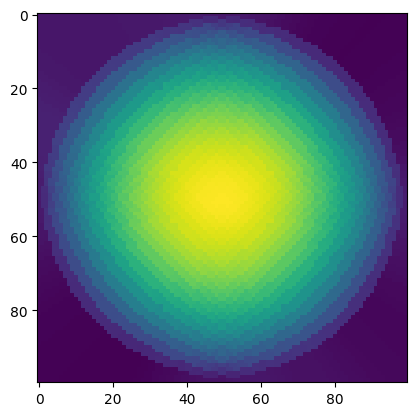

In [283]:
plt.imshow(grid_z0[::-1], cmap="viridis")

In [284]:
import plotly.graph_objects as go

fig = go.Figure(data =
    go.Contour(
        z=grid_z0,
        # contours_coloring='lines',
        colorscale='Hot',
        contours=dict(
            start=coefs.min(),
            end=coefs.max(),
            size=0.05,
            coloring ='heatmap',
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 12,
                color = 'white',
            )
        ),
        line_smoothing=1.3
    ),
    )

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()